 Background removing



### **Let's start!**

## 1. Preparation

# Installing Packages

In [6]:
#Install libraries
!pip install torch
!pip install torchvision
!pip install matplotlib
!pip install scikit-image
!pip install opencv-python
!pip install yacs
!pip install joblib
!pip install natsort
!pip install h5py
!pip install tqdm
!pip install einops
!pip install linformer
!pip install timm
!pip install ptflops
!pip install dataclasses

import torch
import torch.nn as nn
import torch.utils.checkpoint as checkpoint
import collections.abc as container_abcs
from timm.models.layers import DropPath, to_2tuple, trunc_normal_
import torch.nn.functional as F
from einops import rearrange, repeat
from einops.layers.torch import Rearrange
import math
import time
from torch import einsum
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

# Limpiamos la caché de CUDA
torch.cuda.empty_cache()

# Upload the image file
uploaded = files.upload()



## 2. Upload Images and importing

In [9]:
import shutil
import os
from google.colab import files
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Clean and rebuild the image folders
input_folder = 'demo/image_matting/colab/input'
if os.path.exists(input_folder):
    shutil.rmtree(input_folder)
os.makedirs(input_folder)

output_folder = 'demo/image_matting/colab/output'
if os.path.exists(output_folder):
    shutil.rmtree(output_folder)
os.makedirs(output_folder)

# Upload images (PNG or JPG)
image_names = list(files.upload().keys())
for image_name in image_names:
    shutil.move(image_name, os.path.join(input_folder, image_name))


Saving ruled_EX.jpg to ruled_EX.jpg


# Removing ruled line fuction

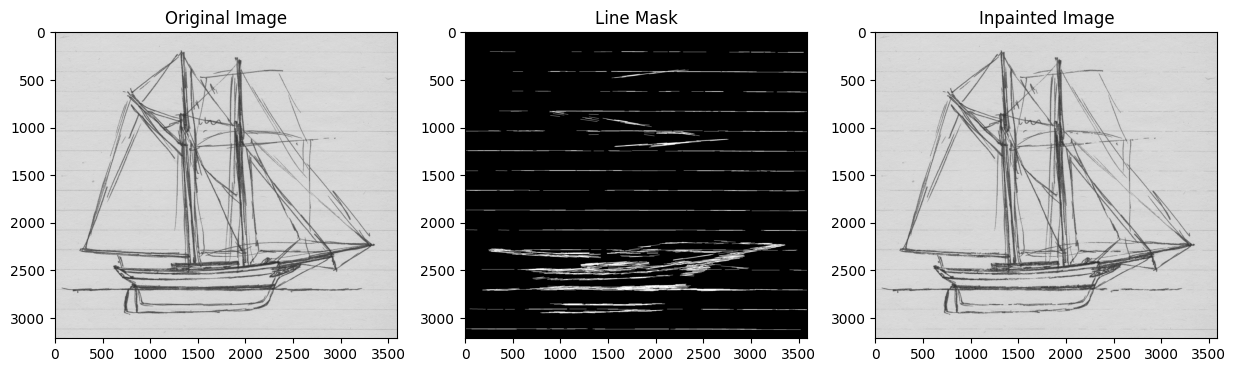

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 689ms/step


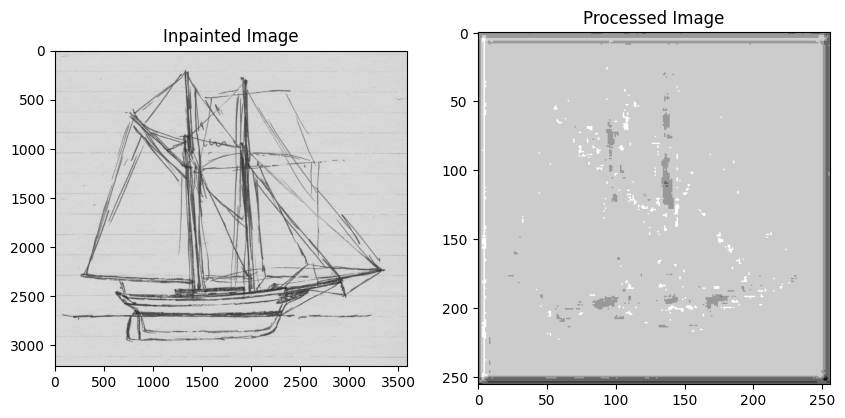

In [11]:
# Define U-Net model
def unet_model(input_size=(256, 256, 1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    up1 = UpSampling2D(size=(2, 2))(conv3)
    conv4 = Conv2D(128, 3, activation='relu', padding='same')(up1)
    up2 = UpSampling2D(size=(2, 2))(conv4)
    conv5 = Conv2D(64, 3, activation='relu', padding='same')(up2)
    outputs = Conv2D(1, 1, activation='sigmoid', padding='same')(conv5)
    model = Model(inputs, outputs)
    return model

# Compile the model
model = unet_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Load and preprocess images
def load_image(path, target_size=(256, 256)):
    img = load_img(path, color_mode='grayscale', target_size=target_size)
    img = img_to_array(img) / 255.0
    img = np.expand_dims(img, axis=0)
    return img

# Process each uploaded image
for image_name in image_names:
    image_path = os.path.join(input_folder, image_name)

    # Load image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Apply edge detection
    edges = cv2.Canny(image, 50, 150, apertureSize=3)

    # Detect lines using Hough Line Transform
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=100, minLineLength=100, maxLineGap=10)

    # Create a mask for the lines
    line_mask = np.zeros_like(image)
    if lines is not None:
        for line in lines:
            for x1, y1, x2, y2 in line:
                # Calculate the angle of the line
                angle = np.arctan2(y2 - y1, x2 - x1) * 180 / np.pi
                length = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
                # Filter horizontal and vertical lines
                if (abs(angle) < 10 or abs(angle) > 170) and length > 100:
                    cv2.line(line_mask, (x1, y1), (x2, y2), 255, 2)

    # Inpaint the image using the mask
    inpainted_image = cv2.inpaint(image, line_mask, 3, cv2.INPAINT_TELEA)

    # Display the result
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title('Original Image')
    plt.imshow(image, cmap='gray')
    plt.subplot(1, 3, 2)
    plt.title('Line Mask')
    plt.imshow(line_mask, cmap='gray')
    plt.subplot(1, 3, 3)
    plt.title('Inpainted Image')
    plt.imshow(inpainted_image, cmap='gray')
    plt.show()

    # Save the inpainted image
    inpainted_image_path = os.path.join(output_folder, image_name)
    cv2.imwrite(inpainted_image_path, inpainted_image)

    # Load and preprocess image for U-Net
    image_for_unet = load_image(inpainted_image_path)
    prediction = model.predict(image_for_unet)

    # Save the processed image
    processed_image_path = os.path.join(output_folder, 'processed_' + image_name)
    processed_image = (prediction[0, :, :, 0] * 255).astype(np.uint8)
    cv2.imwrite(processed_image_path, processed_image)

    # Display the original and processed images
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title('Inpainted Image')
    plt.imshow(inpainted_image, cmap='gray')
    plt.subplot(1, 2, 2)
    plt.title('Processed Image')
    plt.imshow(processed_image, cmap='gray')
    plt.show()

<p align="justify">In the top menu of this session, select <b>Runtime -> Change runtime type</b>, and set <b>Hardware Accelerator</b> to <b>GPU</b>.</p>

<p align="justify">Clone the repository, and download the pre-trained model:</p>


## Download Results

<p align="justify">Download the Zip package of predicted alpha mattes:</p>

In [12]:
zip_filename = 'matte.zip'
if os.path.exists(zip_filename):
  os.remove(zip_filename)

os.system(f"zip -r -j {zip_filename} {output_folder}/*")
files.download(zip_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>